<a href="https://colab.research.google.com/github/LiQuinChing/25-26J-522/blob/main/Copy_of_LSTM45withConvo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb numpy pandas matplotlib seaborn scikit-learn tensorflow PyWavelets opencv-python

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Mounted at /content/drive


In [ ]:
import os
import glob
import random

import numpy as np
import pandas as pd
import wfdb

random.seed(42)

# ---------- PATHS ----------
# ARR CSVs (same as before)
arr_dir = "/content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive"

# NSR from MIT-BIH (WFDB .dat/.hea)
nsr_dir_mit = "/content/drive/MyDrive/Datasets/MIT-BIH normal sinus rhythm/mit-bih-normal-sinus-rhythm-database-1.0.0/mit-bih-normal-sinus-rhythm-database-1.0.0"

# NSR from Kaggle sinus rhythm usability (WFDB-style .hea + .mat)
nsr_dir_kaggle = "/content/drive/MyDrive/Datasets/Kaggle sinus rhythm usability"

# ---------- ARR CSV FILES ----------
arr_csv_files = sorted(glob.glob(os.path.join(arr_dir, "*.csv")))
print("ARR CSV files:", len(arr_csv_files))

# ---------- NSR MIT-BIH .dat FILES ----------
nsr_mit_dat_files = sorted(glob.glob(os.path.join(nsr_dir_mit, "*.dat")))
print("MIT-BIH NSR .dat files:", len(nsr_mit_dat_files))

# ---------- NSR KAGGLE .hea FILES ----------
# We use .hea to get record names; each has .hea + .mat pair
nsr_kaggle_hea_files = sorted(glob.glob(os.path.join(nsr_dir_kaggle, "*.hea")))
print("Kaggle NSR .hea files:", len(nsr_kaggle_hea_files))


ARR CSV files: 48
MIT-BIH NSR .dat files: 18
Kaggle NSR .hea files: 38


In [ ]:
# --------- ARR recordings (label = 1) ----------
# Each element: (csv_path, lead_name)
arr_recordings = []
for csv_path in arr_csv_files:
    arr_recordings.append((csv_path, "MLII"))
    arr_recordings.append((csv_path, "V5"))

print("Total ARR recordings (2 leads each):", len(arr_recordings))


Total ARR recordings (2 leads each): 96


In [ ]:
# --------- NSR recordings (label = 0) ----------
nsr_recordings = []

# 1) MIT-BIH NSR (.dat/.hea) – use up to 2 leads per record
for dat_path in nsr_mit_dat_files:
    rec_name = os.path.splitext(os.path.basename(dat_path))[0]
    record = wfdb.rdrecord(os.path.join(nsr_dir_mit, rec_name))
    n_leads = min(2, record.n_sig)  # use first 1–2 channels

    for ch in range(n_leads):
        nsr_recordings.append((nsr_dir_mit, rec_name, ch))

# 2) Kaggle NSR (.hea + .mat) – also WFDB style
for hea_path in nsr_kaggle_hea_files:
    rec_name = os.path.splitext(os.path.basename(hea_path))[0]
    record = wfdb.rdrecord(os.path.join(nsr_dir_kaggle, rec_name))
    n_leads = min(2, record.n_sig)

    for ch in range(n_leads):
        nsr_recordings.append((nsr_dir_kaggle, rec_name, ch))

print("Total NSR recordings (MIT + Kaggle, up to 2 leads each):", len(nsr_recordings))


Total NSR recordings (MIT + Kaggle, up to 2 leads each): 112


In [ ]:
def split_recordings(rec_list, desired_train=45, val_ratio=0.1, test_ratio=0.1):
    """
    Randomly split a list of recording identifiers into train/val/test.
    - rec_list: list of recording descriptors
    - desired_train: target number of training recordings (e.g., 45)
    - val_ratio, test_ratio: fractions (e.g., 0.1 for 10%)

    Returns: train_list, val_list, test_list
    """
    rec_list = rec_list.copy()
    random.shuffle(rec_list)
    n_total = len(rec_list)

    # Calculate val/test counts from ratios
    n_val = max(1, int(round(n_total * val_ratio)))
    n_test = max(1, int(round(n_total * test_ratio)))

    # Ensure we don't exceed total
    if n_val + n_test >= n_total:
        # fallback: reduce val/test if dataset very small
        n_val = max(1, min(n_val, n_total - 2))
        n_test = max(1, min(n_test, n_total - n_val - 1))

    max_train = max(0, n_total - n_val - n_test)
    n_train = min(desired_train, max_train)

    if n_train < desired_train:
        print(f"Warning: only {n_train} recordings available for train (requested {desired_train}).")

    train = rec_list[:n_train]
    val   = rec_list[n_train:n_train + n_val]
    test  = rec_list[n_train + n_val:n_train + n_val + n_test]

    print(f"Total={n_total} → Train={len(train)}, Val={len(val)}, Test={len(test)}")
    return train, val, test


In [ ]:
arr_train_recs, arr_val_recs, arr_test_recs = split_recordings(arr_recordings, desired_train=45)
nsr_train_recs, nsr_val_recs, nsr_test_recs = split_recordings(nsr_recordings, desired_train=45)

print("ARR train/val/test:", len(arr_train_recs), len(arr_val_recs), len(arr_test_recs))
print("NSR train/val/test:", len(nsr_train_recs), len(nsr_val_recs), len(nsr_test_recs))


Total=96 → Train=45, Val=10, Test=10
Total=112 → Train=45, Val=11, Test=11
ARR train/val/test: 45 10 10
NSR train/val/test: 45 11 11


In [ ]:
def get_fixed_segments(signal, window_size=500, n_segments=10):
    """
    Take a 1D ECG signal and cut it into n_segments of length window_size.
    If the recording is too short, zero-pad it.
    """
    needed = window_size * n_segments

    if len(signal) < needed:
        padded = np.zeros(needed)
        padded[:len(signal)] = signal
        signal = padded

    signal = signal[:needed]

    segments = []
    for k in range(n_segments):
        start = k * window_size
        end = start + window_size
        segments.append(signal[start:end])
    return np.array(segments)


def choose_lead(df, requested_lead):
    """
    For ARR CSVs: choose MLII/V5 or fallback lead.
    """
    cols = list(df.columns)

    if requested_lead in cols:
        return requested_lead, False

    fallback_order = ['MLII', 'V5', 'V2', 'V1', 'II', 'III', 'aVR', 'aVL', 'aVF']
    for fb in fallback_order:
        if fb in cols:
            return fb, True

    return None, False


5. Build segment datasets X, y (updated for new NSR structure)

We keep exactly the same segmentation logic — each recording → 10 segments of length 500.
Only change is how we read NSR: tuples now include base_dir

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_train, y_train = [], []
X_val,   y_val   = [], []
X_test,  y_test  = [], []

# ========== ARR (label = 1) ==========
for csv_path, lead in arr_train_recs:
    df = pd.read_csv(csv_path)
    lead_to_use, used_fallback = choose_lead(df, lead)

    if lead_to_use is None:
        print(f"Warning: no suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)

    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_train.append(segs)
    y_train.extend([1] * len(segs))

for csv_path, lead in arr_val_recs:
    df = pd.read_csv(csv_path)
    lead_to_use, used_fallback = choose_lead(df, lead)

    if lead_to_use is None:
        print(f"Warning: no suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)

    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_val.append(segs)
    y_val.extend([1] * len(segs))

for csv_path, lead in arr_test_recs:
    df = pd.read_csv(csv_path)
    lead_to_use, used_fallback = choose_lead(df, lead)

    if lead_to_use is None:
        print(f"Warning: no suitable lead found in {csv_path}. Skipping.")
        continue

    if used_fallback:
        print(f"Info: Lead '{lead}' not found in {csv_path}, using '{lead_to_use}' instead.")

    signal = df[lead_to_use].values.astype(float)
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)

    segs = get_fixed_segments(signal, window_size=500, n_segments=10)
    X_test.append(segs)
    y_test.extend([1] * len(segs))


Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/208.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/117.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/107.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/210.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/202.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/231.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/201.csv, using 'MLII' instead.
Info: Lead 'V5' not found in /content/drive/MyDrive/Datasets/MIT-BIH Arrhythmia dataset/archive/122.csv, using 

NSR (label = 0) – now from MIT + Kaggle

In [ ]:
# ========== NSR (label = 0) ==========
for base_dir, rec_name, ch in nsr_train_recs:
    record = wfdb.rdrecord(os.path.join(base_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)

    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)

    X_train.append(segs)
    y_train.extend([0] * len(segs))

for base_dir, rec_name, ch in nsr_val_recs:
    record = wfdb.rdrecord(os.path.join(base_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)

    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)

    X_val.append(segs)
    y_val.extend([0] * len(segs))

for base_dir, rec_name, ch in nsr_test_recs:
    record = wfdb.rdrecord(os.path.join(base_dir, rec_name))
    signal = record.p_signal[:, ch].astype(float)

    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
    segs = get_fixed_segments(signal, window_size=500, n_segments=10)

    X_test.append(segs)
    y_test.extend([0] * len(segs))


6. Stack, reshape for LSTM, and one-hot encode (same as before)

In [ ]:
# Stack segments: list of [10, 500] arrays → big [N, 500] array
X1d_train = np.vstack(X_train)
X1d_val   = np.vstack(X_val)
X1d_test  = np.vstack(X_test)

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

print("Train segments:", X1d_train.shape, "labels:", y_train.shape)
print("Val segments:  ", X1d_val.shape,   "labels:", y_val.shape)
print("Test segments: ", X1d_test.shape,  "labels:", y_test.shape)

print("Train class counts → NSR(0):", np.sum(y_train == 0), "ARR(1):", np.sum(y_train == 1))
print("Val   class counts → NSR(0):", np.sum(y_val == 0),   "ARR(1):", np.sum(y_val == 1))
print("Test  class counts → NSR(0):", np.sum(y_test == 0),  "ARR(1):", np.sum(y_test == 1))

# Reshape for LSTM: (samples, timesteps, features)
X1d_train = X1d_train.reshape((-1, 500, 1))
X1d_val   = X1d_val.reshape((-1, 500, 1))
X1d_test  = X1d_test.reshape((-1, 500, 1))

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_oh   = encoder.transform(y_val.reshape(-1, 1))
y_test_oh  = encoder.transform(y_test.reshape(-1, 1))

print("Classes:", encoder.categories_)


Train segments: (900, 500) labels: (900,)
Val segments:   (210, 500) labels: (210,)
Test segments:  (210, 500) labels: (210,)
Train class counts → NSR(0): 450 ARR(1): 450
Val   class counts → NSR(0): 110 ARR(1): 100
Test  class counts → NSR(0): 110 ARR(1): 100
Classes: [array([0, 1])]


Data prepdone now going for the training of the LSTM model.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report


the modified part of the model with convo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dropout, Dense,
    Conv1D, MaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ----- Conv + BiLSTM architecture -----
model_lstm = Sequential([
    Input(shape=(500, 1)),

    # Small Conv block to learn local ECG morphology
    Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),       # sequence length: 500 -> 250

    # Temporal modelling with BiLSTM
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32)),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.4),

    Dense(2, activation='softmax')   # NSR vs ARR
])

model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4),          # slightly smaller LR
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 500, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,218 (364.13 KB)

 Trainable params: 93,218 (364.13 KB)

 Non-trainable params: 0 (0.00 B)

4. early stopping and Train the model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6
)

history_lstm = model_lstm.fit(
    X1d_train, y_train_oh,
    validation_data=(X1d_val, y_val_oh),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)


Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.4658 - auc: 0.4588 - loss: 0.6946 - val_accuracy: 0.4857 - val_auc: 0.6666 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - accuracy: 0.4644 - auc: 0.5246 - loss: 0.6911 - val_accuracy: 0.5095 - val_auc: 0.7015 - val_loss: 0.6799 - learning_rate: 1.0000e-04
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.4861 - auc: 0.5426 - loss: 0.6879 - val_accuracy: 0.5095 - val_auc: 0.6945 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - accuracy: 0.5172 - auc: 0.5523 - loss: 0.6883 - val_accuracy: 0.5381 - val_auc: 0.7173 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.5582 - auc: 0.5886 - loss: 0.6844 - val_accuracy: 0.5476 - val_auc: 0.7138 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - 

5. Evaluate on the test set

In [ ]:
test_loss, test_acc, test_auc = model_lstm.evaluate(X1d_test, y_test_oh, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Test loss: 0.5846
Test accuracy: 0.7333
Test AUC: 0.7889


6. Predictions and confusion matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step


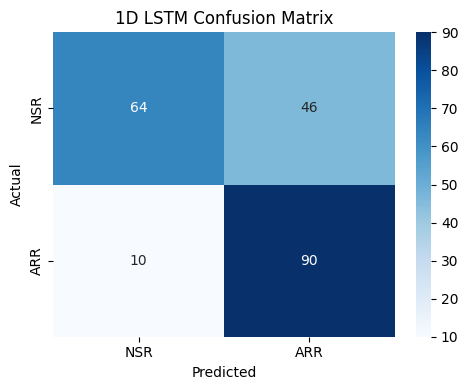

In [ ]:
# Predict probabilities
y_pred_proba = model_lstm.predict(X1d_test)
# Convert to class labels (0 = NSR, 1 = ARR)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# y_test should already be your integer labels (0/1)
y_true_labels = y_test

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['NSR', 'ARR'],
    yticklabels=['NSR', 'ARR']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('1D LSTM Confusion Matrix')
plt.tight_layout()
plt.show()
